to examine the rho (and also delta!) score histograms!

In [1]:
#imports
import uproot as ur
import numpy as np

data_path = '/fast_scratch/atlas_images/v01-45/'

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
import graph_util as gu
import plot_util as pu
import matplotlib.pyplot as plt

In [3]:
#testing the rho data on the no glob model!!!
file = np.load(data_path+'nn_rhodata.npz')
model_nog = tf.keras.models.load_model(data_path+'w8_pfn_noglob_2.hdf5')


In [4]:
X_test = file['arr_2']
eta_test = file['arr_5']

In [6]:
eta_ranges = np.arange(0., 3.1, .1)+.05

selec1 = abs(eta_test) < 0.5
selec2 = (abs(eta_test) >= .5) & (abs(eta_test) < 1.)
selec3 = (abs(eta_test) >= 1.) & (abs(eta_test) < 1.5)
selec4 = (abs(eta_test) >= 1.5) & (abs(eta_test) < 2.)
selec5 = (abs(eta_test) >= 2.) & (abs(eta_test) < 2.5)
selec6 = (abs(eta_test) >= 2.5) & (abs(eta_test) < 3.1)


eta_sel = [selec1, selec2, selec3, selec4, selec5, selec6]

In [18]:
eta_sel[0]

array([False, False, False, ..., False, False, False])

In [10]:
predics = []
for selection in eta_sel:
    preds = model_nog.predict(X_test[selection], batch_size=1000)
    predics.append(preds)

In [11]:
predics

[array([[0.8302374 , 0.16976267],
        [0.38292143, 0.61707854],
        [0.8662398 , 0.13376018],
        ...,
        [0.00129314, 0.9987068 ],
        [0.9797259 , 0.02027414],
        [0.13155092, 0.86844915]], dtype=float32),
 array([[0.00211403, 0.997886  ],
        [0.9799548 , 0.02004526],
        [0.36948577, 0.63051426],
        ...,
        [0.9118965 , 0.08810352],
        [0.7960106 , 0.20398939],
        [0.7465104 , 0.2534896 ]], dtype=float32),
 array([[4.7435290e-03, 9.9525648e-01],
        [7.3219037e-01, 2.6780957e-01],
        [8.6423039e-01, 1.3576961e-01],
        ...,
        [7.7600062e-01, 2.2399937e-01],
        [5.6528440e-03, 9.9434716e-01],
        [4.1022697e-05, 9.9995899e-01]], dtype=float32),
 array([[2.7194167e-02, 9.7280586e-01],
        [6.7732447e-01, 3.2267553e-01],
        [6.6931915e-01, 3.3068088e-01],
        ...,
        [9.5895493e-01, 4.1045070e-02],
        [4.9167757e-06, 9.9999511e-01],
        [7.5785676e-03, 9.9242145e-01]], dtype=fl

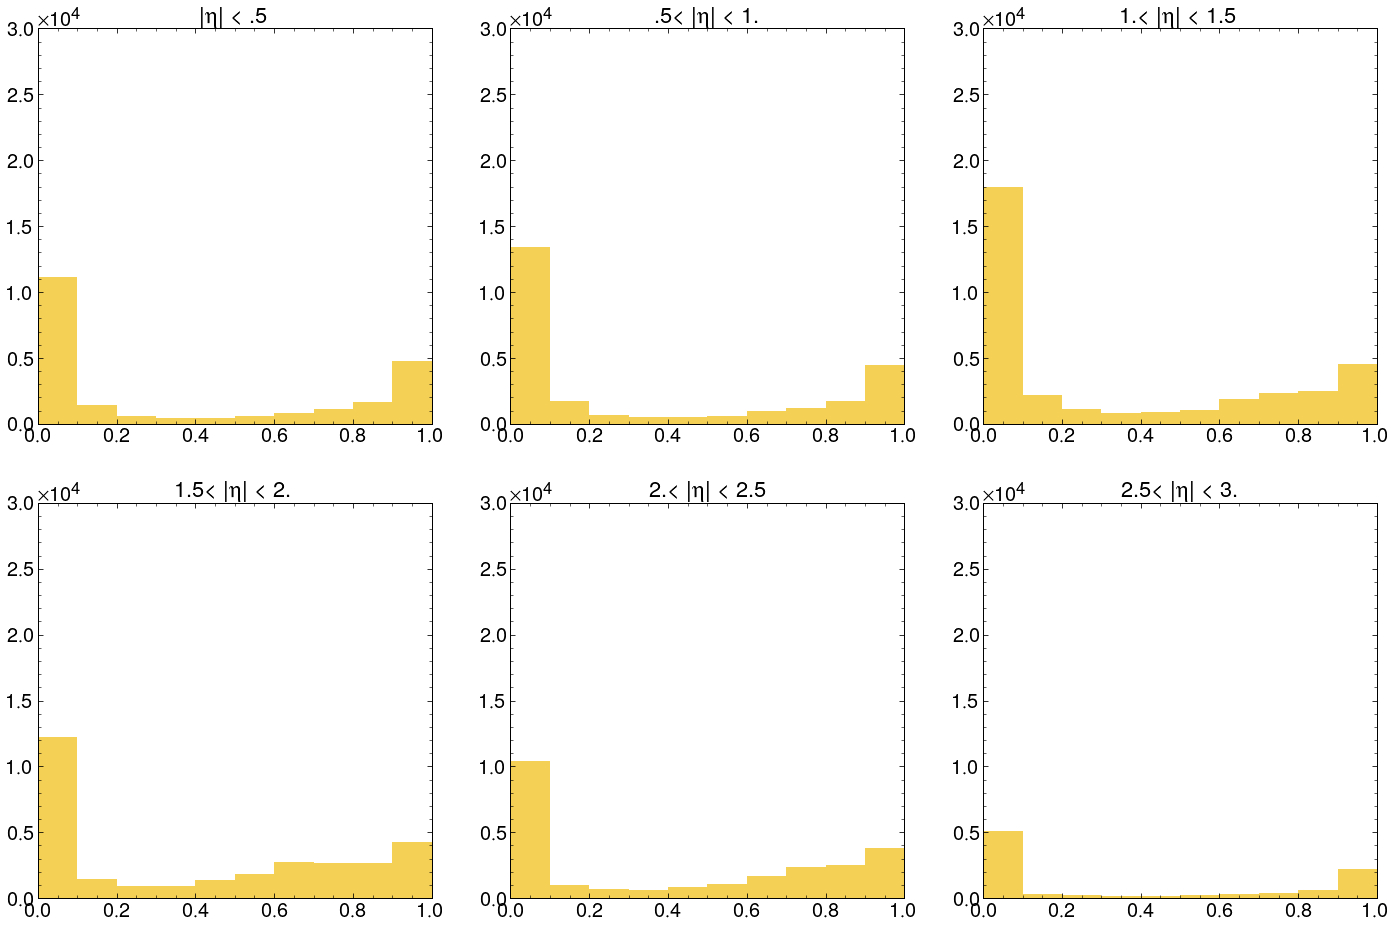

In [15]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=[24,16])
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ranges = ['|$\eta$| < .5', '.5< |$\eta$| < 1.', '1.< |$\eta$| < 1.5', '1.5< |$\eta$| < 2.', '2.< |$\eta$| < 2.5', '2.5< |$\eta$| < 3.']

for i in range(len(predics)):
    prob1, prob2 = predics[i].T
    axes[i].set_xlim(0,1)
    axes[i].set_ylim(0,3e4)
    axes[i].set_title(ranges[i])
    axes[i].hist(prob1, color='xkcd:maize') #probability of pi0
    #axes[i].hist(prob2, color='xkcd:ochre', alpha=.6) #don't need both!!! redundant info

In [16]:
#now try binning in pT!!!
pt_test = file['arr_11']

In [17]:
min(pt_test)

0.08347882

In [18]:
max(pt_test)

1903.7311

In [19]:
log_pt = np.log10(pt_test)
min(log_pt), max(log_pt)

(-1.0784237, 3.2796056)

In [21]:
Pt_range = np.linspace(min(log_pt), max(log_pt), num=6)

In [22]:
Pt_range

array([-1.07842374, -0.20681787,  0.66478801,  1.53639388,  2.40799975,
        3.27960563])

In [27]:
Pt_sel = [log_pt < Pt_range[1]]
for i in range(1, len(Pt_range)):
    selec_ = (log_pt >= Pt_range[i-1]) & (log_pt < Pt_range[i])
    Pt_sel.append(selec_)

In [28]:
np.where(Pt_sel[0] == True)

(array([    15,     16,     28, ..., 149977, 149980, 149986]),)

In [29]:
predics_pt = []
for selection in Pt_sel:
    preds = model_nog.predict(X_test[selection], batch_size=1000)
    predics_pt.append(preds)

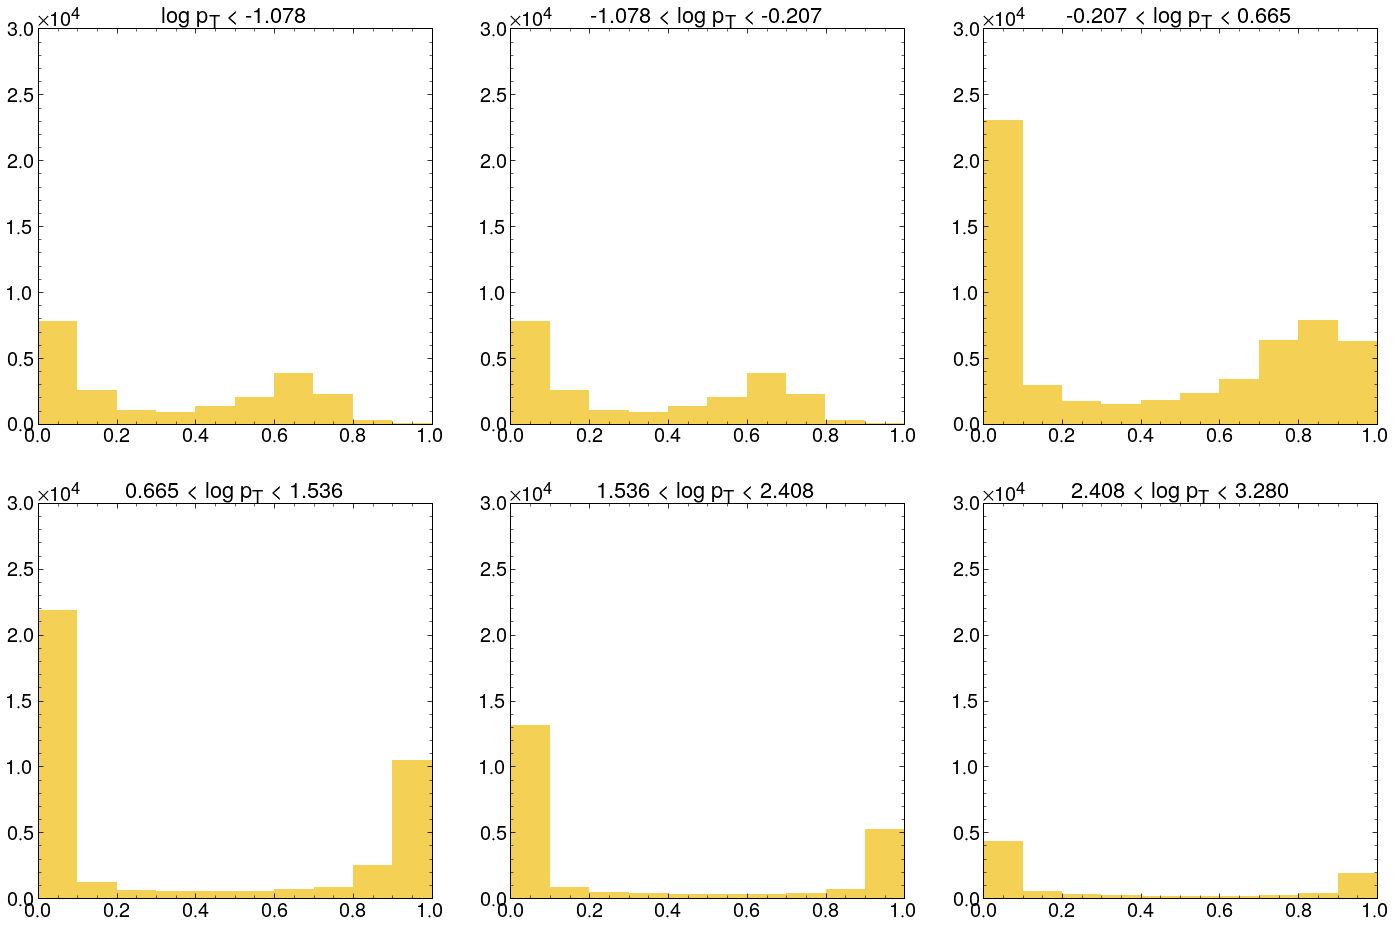

In [32]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=[24,16])
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ranges = ['log $p_T$ < %.3f'%Pt_range[0], '%.3f < log $p_T$ < %.3f'%(Pt_range[0], Pt_range[1]), '%.3f < log $p_T$ < %.3f'%(Pt_range[1], Pt_range[2]), '%.3f < log $p_T$ < %.3f'%(Pt_range[2], Pt_range[3]), '%.3f < log $p_T$ < %.3f'%(Pt_range[3], Pt_range[4]), '%.3f < log $p_T$ < %.3f'%(Pt_range[4],Pt_range[5])]

for i in range(len(predics_pt)):
    prob1, prob2 = predics_pt[i].T
    axes[i].set_xlim(0,1)
    axes[i].set_ylim(0,3e4)
    axes[i].set_title(ranges[i])
    axes[i].hist(prob1, color='xkcd:maize')

### now onto delta!

In [3]:
#testing the rho data on the no glob model!!!
file = np.load(data_path+'nn_deltadata.npz')
model_nog = tf.keras.models.load_model(data_path+'w8_pfn_noglob_2.hdf5')


In [5]:
X_test = file['arr_2']
eta_test = file['arr_5']

In [9]:
pt_test = file['arr_11']

In [7]:
predics = []
for selection in eta_sel:
    preds = model_nog.predict(X_test[selection], batch_size=1000)
    predics.append(preds)

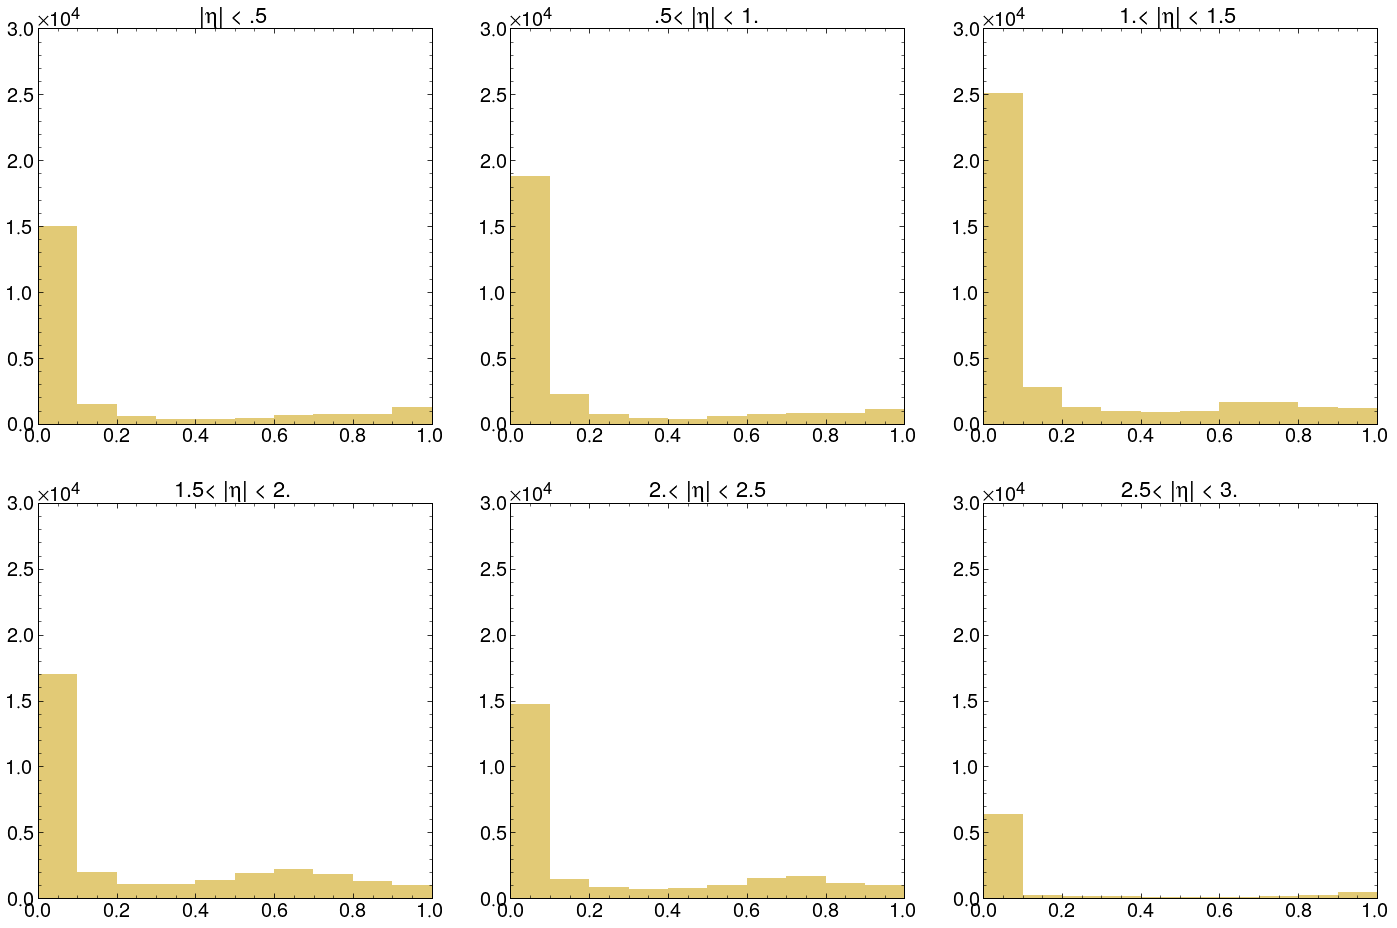

In [8]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=[24,16])
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ranges = ['|$\eta$| < .5', '.5< |$\eta$| < 1.', '1.< |$\eta$| < 1.5', '1.5< |$\eta$| < 2.', '2.< |$\eta$| < 2.5', '2.5< |$\eta$| < 3.']

for i in range(len(predics)):
    prob1, prob2 = predics[i].T
    axes[i].set_xlim(0,1)
    axes[i].set_ylim(0,3e4)
    axes[i].set_title(ranges[i])
    axes[i].hist(prob1, color='xkcd:sand')

In [10]:
log_pt = np.log10(pt_test)
Pt_range = np.linspace(min(log_pt), max(log_pt), num=6)

Pt_sel = [log_pt < Pt_range[1]]
for i in range(1, len(Pt_range)):
    selec_ = (log_pt >= Pt_range[i-1]) & (log_pt < Pt_range[i])
    Pt_sel.append(selec_)

In [11]:
predics_pt = []
for selection in Pt_sel:
    preds = model_nog.predict(X_test[selection], batch_size=1000)
    predics_pt.append(preds)

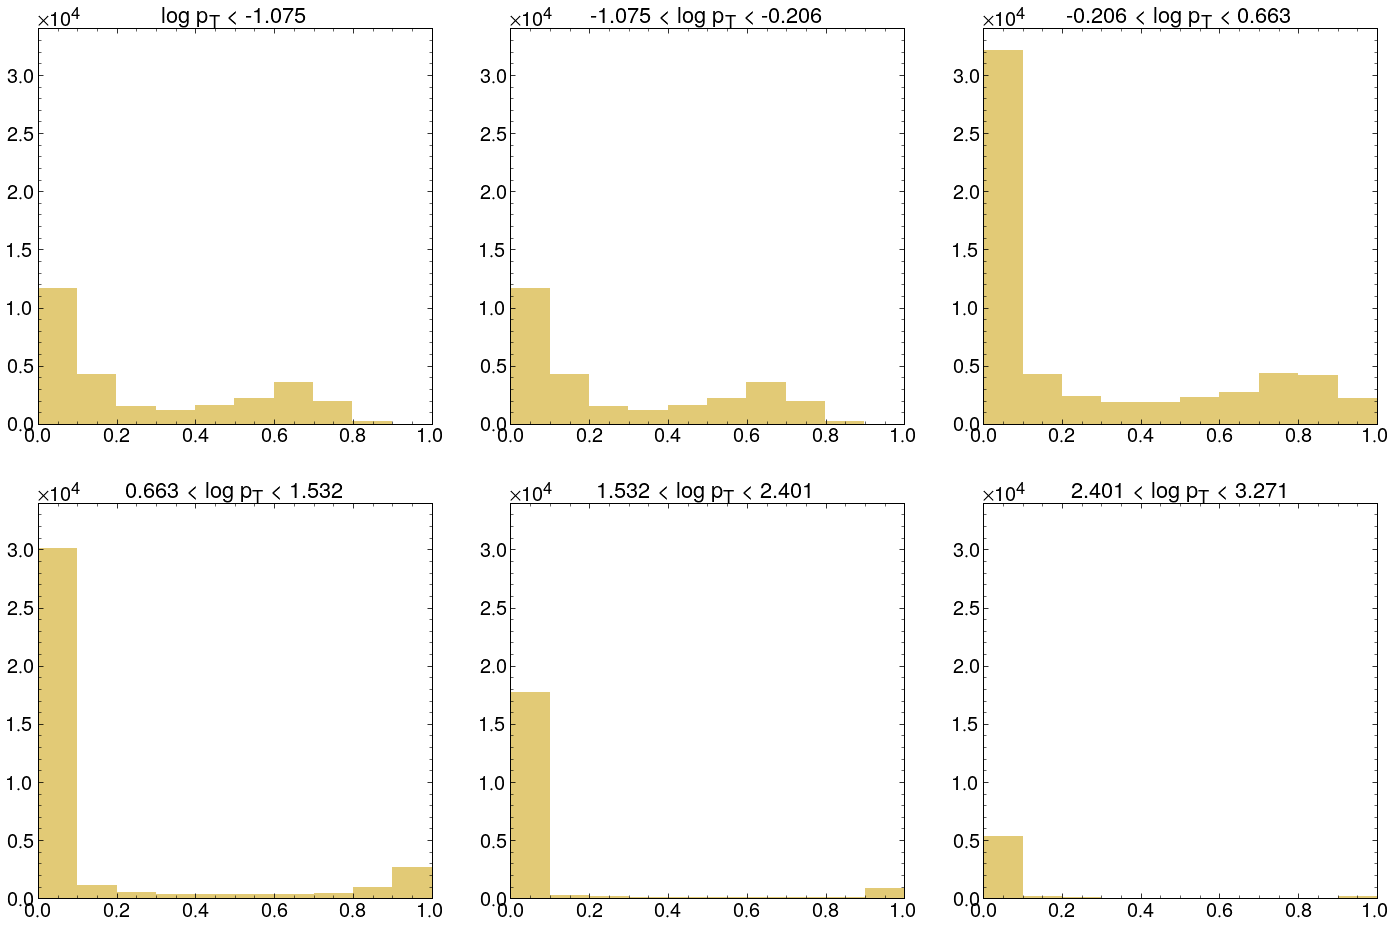

In [14]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=[24,16])
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
ranges = ['log $p_T$ < %.3f'%Pt_range[0], '%.3f < log $p_T$ < %.3f'%(Pt_range[0], Pt_range[1]), '%.3f < log $p_T$ < %.3f'%(Pt_range[1], Pt_range[2]), '%.3f < log $p_T$ < %.3f'%(Pt_range[2], Pt_range[3]), '%.3f < log $p_T$ < %.3f'%(Pt_range[3], Pt_range[4]), '%.3f < log $p_T$ < %.3f'%(Pt_range[4],Pt_range[5])]

for i in range(len(predics_pt)):
    prob1, prob2 = predics_pt[i].T
    axes[i].set_xlim(0,1)
    axes[i].set_ylim(0,3.4e4)
    axes[i].set_title(ranges[i])
    axes[i].hist(prob1, color='xkcd:sand')